In [2]:
import numpy as np
import csv
import os
import time
import json
import mysql.connector as mysql

from sklearn.decomposition import PCA
import umap

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm  # for kdemultivariate

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                            'database':'test_pubmed',
                            'use_pure':True}



journals = ['J. Neurophysiol.', 'Neuroimage']  # journals = ['Brain Res.', 'J. Virol.']

journal_colors = [[0, 0.25, 0.75, 0.25],
                  [0, 0.75, 0.25, 0.25]]


# table names corresponding to embedding conditions
embedding_conditions = ['emb_w2v_pm',
              'emb_w2v_pm_pmc',
              'emb_w2v_wiki_pm_pmc']

# todo also check representations composed from cls & tokens
#  maybe directly optimize on this

compare_embeddings = {}


In [4]:
for condition in embedding_conditions:

    compare_embeddings[condition] = {}

    db = mysql.connect(**client_config)

    for i_journal, journal in enumerate(journals):

        start_time = time.time()

        sql = '''SELECT {}.embedding
                FROM {}
                JOIN metadata ON {}.pmid=metadata.pmid
                WHERE metadata.journal = '{}' '''.format(condition, condition, condition, journal)
        print(sql)

        cursor = db.cursor()
        cursor.execute(sql)
        results = cursor.fetchall()
        print(len(results))
        cursor.close()
                
        compare_embeddings[condition][journal] = [np.frombuffer(e[0],
                                                                dtype="float64") for e in results]

        end_time = time.time()
        print("journals enumerated in {} s".format(end_time - start_time))
        print()
        
    db.close()
    
    # take a quick look    
    print(condition, journal)
    print('first few entries of the embedding vector ok?: ')
    print(compare_embeddings[condition][journal][0][:10])
    print()

SELECT emb_w2v_pm.embedding
                FROM emb_w2v_pm
                JOIN metadata ON emb_w2v_pm.pmid=metadata.pmid
                WHERE metadata.journal = 'J. Neurophysiol.' 
20115
journals enumerated in 20.3499858379364 s

SELECT emb_w2v_pm.embedding
                FROM emb_w2v_pm
                JOIN metadata ON emb_w2v_pm.pmid=metadata.pmid
                WHERE metadata.journal = 'Neuroimage' 
9886
journals enumerated in 0.39927077293395996 s

emb_w2v_pm Neuroimage
first few entries of the embedding vector ok?: 
[-0.00096936 -0.01687121 -0.01624973  0.00177859 -0.02714312 -0.14195792
  0.03875798  0.0152756  -0.0219088  -0.08515496]

SELECT emb_w2v_pm_pmc.embedding
                FROM emb_w2v_pm_pmc
                JOIN metadata ON emb_w2v_pm_pmc.pmid=metadata.pmid
                WHERE metadata.journal = 'J. Neurophysiol.' 
20115
journals enumerated in 2.926140785217285 s

SELECT emb_w2v_pm_pmc.embedding
                FROM emb_w2v_pm_pmc
                JOIN metadata 

In [5]:

import math
import random

def cos_sim_helper(d_embeddings, title_text='cosine similarities by class'):
    
    ## partition samples in embedding dictionary, for cross-validation 
    #condition = embedding_conditions[0]
    d_partition = {}
    N_partitions = 2  # currently not supporting other choices of N_partitions

    for journal in journals:
        d_partition[journal] = []
        this_journal = d_embeddings[journal].copy()

        L_partition = int(math.ceil((1.0/N_partitions)*len(this_journal)))
        random.shuffle(this_journal)  # shuffle in place

        curPosition = 0
        for partition in range(N_partitions):
            partition_samples = this_journal[curPosition:(curPosition+L_partition)]
            curPosition = L_partition
            d_partition[journal].append(partition_samples)
        

    ### measure cosine similarity within and between samples
    cos_sim_xvalid = {}

    my_colors = [[[0,0.5, 0.5],[0.75, 0.25, 0.5]],
                 [[0.75, 0.5, 0.5], [0, 0.75, 0.25]]]

    plt.figure()

    for i_src, src_journal in enumerate(journals):
        src_samples = d_partition[src_journal][0]

        for i_tgt, tgt_journal in enumerate(journals):
            tgt_samples = d_partition[tgt_journal][1]

            R = cosine_similarity(src_samples, tgt_samples)
            cos_sim_xvalid[(src_journal, tgt_journal)] = R


            plt.hist(R.flatten(),
                     density=True,
                     histtype='step',
                     bins=100,
                     color=my_colors[i_src][i_tgt],
                     alpha=0.5,
                     linewidth=2)
            
            plt.xlabel('cosine similarity')
            plt.ylabel('density')
            plt.title(title_text)
            
    return cos_sim_xvalid

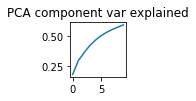

J. Neurophysiol.
20115
Neuroimage
9886


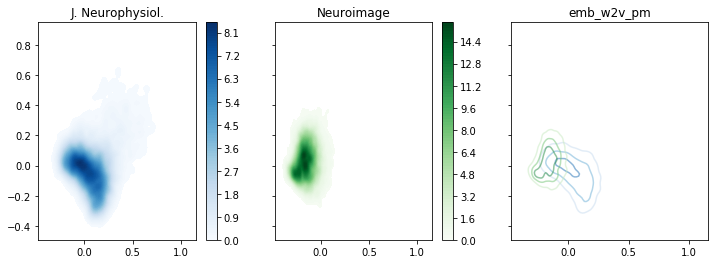

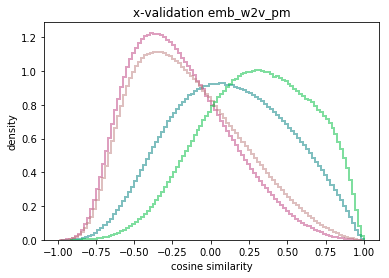

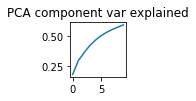

J. Neurophysiol.
20115
Neuroimage
9886


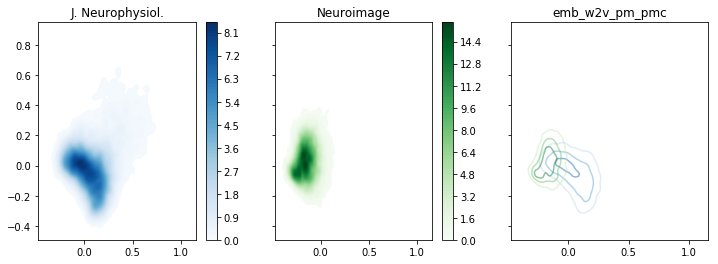

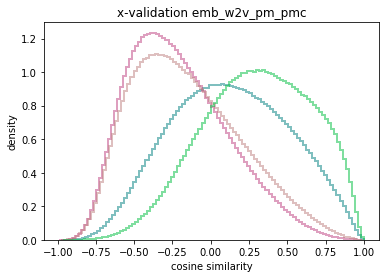

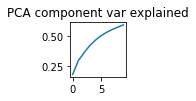

J. Neurophysiol.
20115
Neuroimage
9886


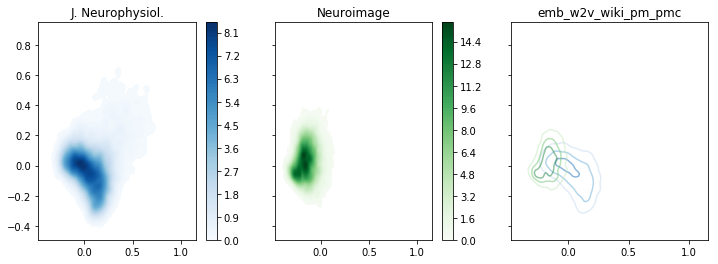

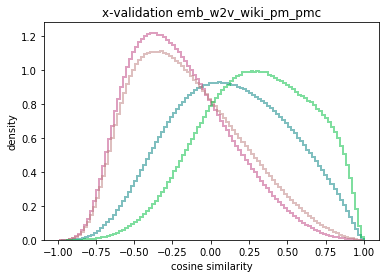

In [6]:
# todo would be nice to align these spaces and then compare

D = 200
D_pca = 10   # most of the variance preserved at around 300 d

pca_models = []

for i_cond, condition in enumerate(embedding_conditions):
    
    all_articles = np.zeros((0,D))
    
    # full list of samples across journals, to feed to pca
    for journal in journals:
        thisjournal = compare_embeddings[condition][journal].copy()
        all_articles = np.vstack( (all_articles, thisjournal))
        
    # get pca for this embedding condition
    pca = PCA(n_components=D_pca)
    pc = pca.fit_transform(all_articles)
    pca_models.append(pca)
    
    # var explained
    plt.figure(figsize=(1,1))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA component var explained')  
    plt.show()
    
    ## 2D pca comparison of journals ##
    (f, ax) = plt.subplots(1, len(journals)+1, sharex='all', sharey='all',
                      figsize=(12,4))
    
    pca_dictionary = {}
    cmap_key = ['Blues','Greens']
    for i_journal, journal in enumerate(journals):
        print(journal)
        samples = compare_embeddings[condition][journal].copy()
        print(len(samples))
        pc = pca.transform(samples)
        pca_dictionary[journal] = pc
        #ax[i_journal].scatter(pc[:,0], pc[:,1],color=journal_colors[i_journal])
        
        sns.kdeplot(pc[:,0],pc[:,1],n_levels=100,
                 shade=True, shade_lowest=False,
                 alpha=1, cmap=cmap_key[i_journal], cbar=True,
                 ax = ax[i_journal])
        ax[i_journal].set_title(journal)

        sns.kdeplot(pc[:,0],pc[:,1],n_levels=3,
                    shade=False,
                    alpha=0.5,
                    cmap=cmap_key[i_journal],
                    ax = ax[len(ax)-1])
        #ax[i_journal].scatter(pc[:,0], pc[:,1],
        #            color=journal_colors[i_journal],marker='.')

        ax[len(ax)-1].set_title(condition)

        plt.savefig('nphys vs nimg {} density.png'.format(condition))
        plt.savefig('nphys vs nimg {} density.svg'.format(condition))
        
    # plot cosine similarity xvalidation test
    xvalid = cos_sim_helper(pca_dictionary,
                            title_text='x-validation {}'.format(condition))
    plt.savefig('pca xvalidation 2D {}.png'.format(condition))
    plt.savefig('pca xvalidation 2D {}.svg'.format(condition))